# Sentiment Analysis: The Simpsons

imports

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot,plot
import nltk
import re
import random
%matplotlib inline

from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
from nrclex import NRCLex
from nltk.corpus import stopwords

from PIL import Image
import matplotlib.image as mpimg
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [59]:
import warnings
warnings.filterwarnings("ignore")

The dataset

In [60]:
df = pd.read_csv('simpsons_script_lines.csv')
df.head()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33


In [61]:
df.shape

(158271, 13)

We'll take the first 10000 rows

In [62]:
df = df.head(10000)

In [63]:
df.shape

(10000, 13)

In [64]:
df = df.dropna()

In [65]:
df[df['word_count'] == 'true']

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
8082,17667,59,87,"Singers: (SINGING) ""IT'S THE FIRST ANNUAL MONT...",442000,True,276.0,636.0,Singers,Springfield Civic Center,IT'S THE FIRST ANNUAL MONTGOMERY BURNS/ AWARD ...,455000,true


In [66]:
df.loc[df['word_count'] == 'true', 'word_count'] = 84

In [67]:
df['word_count'] = df['word_count'].astype(str).astype(int)


In [68]:
df.dtypes

id                      int64
episode_id              int64
number                  int64
raw_text               object
timestamp_in_ms        object
speaking_line          object
character_id           object
location_id           float64
raw_character_text     object
raw_location_text      object
spoken_words           object
normalized_text        object
word_count              int32
dtype: object

## TEXT PREPROCESSING

In [69]:
#nltk.download('wordnet')

In [70]:
descriptions = []
for description in df['normalized_text']:
    description = re.sub("[^a-zA-Z]", " ", description)
    description = description.lower()
    description = nltk.word_tokenize(description)
    description = [word for word in description if not word in set(stopwords.words('english'))]

    lemma = nltk.WordNetLemmatizer()
    description = [lemma.lemmatize(word) for word in description]
    description = ' '.join(description)
    descriptions.append(description)

df['normalized_text_new'] = descriptions
df.head(5)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,normalized_text_new
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31,actually little sometimes disease magazine new...
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3,wheres mr bergstrom
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22,dont know although id sure like talk didnt tou...
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5,life worth living
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33,poll open end recess case decided put thought ...


In [71]:
for i, row in df.iterrows():
    print(row['character_id'], row['raw_character_text'])

464.0 Miss Hoover
9.0 Lisa Simpson
464.0 Miss Hoover
9.0 Lisa Simpson
40.0 Edna Krabappel-Flanders
38.0 Martin Prince
40.0 Edna Krabappel-Flanders
8.0 Bart Simpson
9.0 Lisa Simpson
469.0 Landlady
9.0 Lisa Simpson
469.0 Landlady
9.0 Lisa Simpson
469.0 Landlady
9.0 Lisa Simpson
8.0 Bart Simpson
101.0 Nelson Muntz
8.0 Bart Simpson
467.0 Terri/sherri
8.0 Bart Simpson
25.0 Milhouse Van Houten
8.0 Bart Simpson
8.0 Bart Simpson
25.0 Milhouse Van Houten
8.0 Bart Simpson
53.0 Wendell Borton
8.0 Bart Simpson
40.0 Edna Krabappel-Flanders
8.0 Bart Simpson
40.0 Edna Krabappel-Flanders
470.0 Kid Reporter
41.0 Conductor
9.0 Lisa Simpson
465.0 BERGSTROM
9.0 Lisa Simpson
465.0 BERGSTROM
9.0 Lisa Simpson
465.0 BERGSTROM
9.0 Lisa Simpson
465.0 BERGSTROM
9.0 Lisa Simpson
465.0 BERGSTROM
9.0 Lisa Simpson
465.0 BERGSTROM
9.0 Lisa Simpson
465.0 BERGSTROM
465.0 BERGSTROM
9.0 Lisa Simpson
41.0 Conductor
9.0 Lisa Simpson
465.0 BERGSTROM
2.0 Homer Simpson
2.0 Homer Simpson
9.0 Lisa Simpson
1.0 Marge Simpson
9.0 

In [72]:
val_homer=[]
val_bart=[]
val_marge=[]
val_lisa=[]

for i,row in df.iterrows():
    val = row['normalized_text_new']
    if row['character_id'] == 2:
        val_homer.append(val)
    elif row['character_id']== 8:
        val_bart.append(val)
    elif row['character_id'] == 1:
        val_marge.append(val)
    elif row['character_id']== 9:
        val_lisa.append(val) 

Cleaning the text

In [73]:
stop = stopwords.words('english')

In [74]:
pat = r'\b(?:{})\b'.format('|'.join(stop))
def text_cleaning(val_list):
    df1 = DataFrame (val_list, columns=['normalized_text_new']).dropna()
    df1["normalized_text_new"] = df1["normalized_text_new"].str.replace(pat, '')
    df1["normalized_text_new"] = df1["normalized_text_new"].str.replace(r'\s+', ' ')
    return df1

In [75]:
bart = text_cleaning(val_bart)
homer = text_cleaning(val_homer)
marge = text_cleaning(val_marge)
lisa = text_cleaning(val_lisa)

### Word Cloud

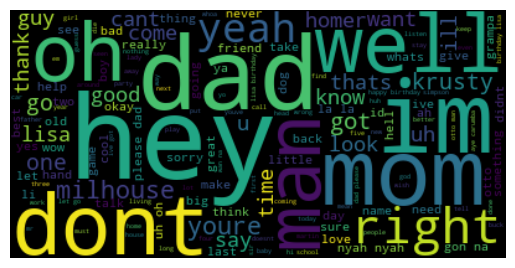

In [76]:
wc = WordCloud()
wc.generate(' '.join(bart['normalized_text_new']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

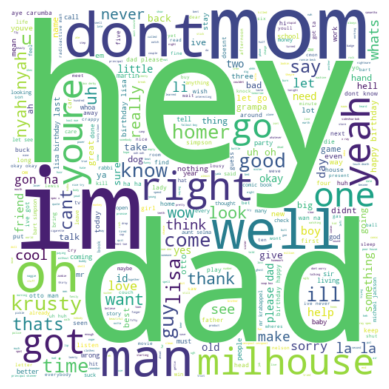

In [77]:
wc = WordCloud(background_color="white", max_words=2000,
               stopwords=STOPWORDS, max_font_size=256,
               random_state=42, width=500, height=500)
wc.generate(' '.join(bart['normalized_text_new']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [78]:
def wordcloud(char,img_path,color):
    plt.subplots(figsize=(10,10))
    mask = np.array(Image.open(img_path))
    wc = WordCloud(stopwords=STOPWORDS, 
                   mask=mask, background_color="white", contour_width=2, contour_color=color,
                   max_words=2000, max_font_size=256,
                   random_state=42, width=mask.shape[1],
                   height=mask.shape[0])
    wc.generate(' '.join(char['normalized_text_new']))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

## Unigrams, Bigrams and Trigrams
___

In [79]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [80]:
def plot(x,char,name,w,p):
    common_words = x(char['normalized_text_new'], 20)
    common_words_df = DataFrame (common_words,columns=['word','freq'])

    plt.figure(figsize=(16, 10))
    sns.barplot(x='word', y='freq', data=common_words_df,palette=p)
    plt.title("Top 20 "+w+" used by "+name, fontsize=16)
    plt.ylabel("Frequency", fontsize=14)
    plt.yticks(fontsize=13)
    plt.xticks(rotation=90, fontsize=13)
    plt.xlabel("");

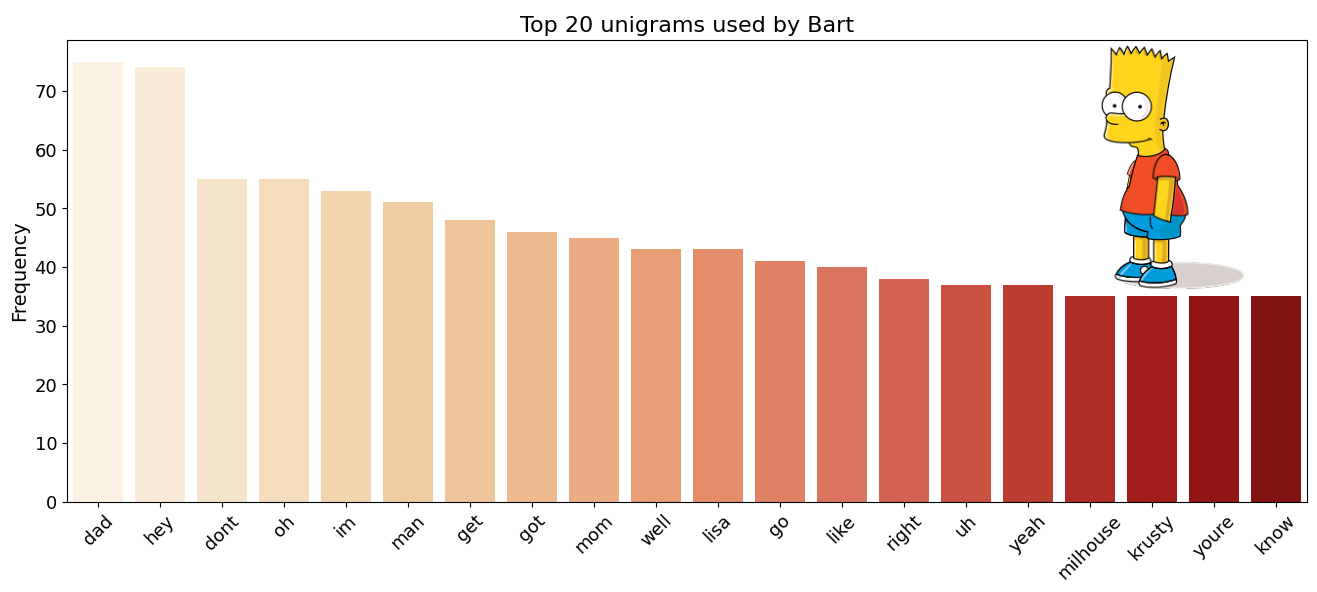

In [95]:
common_words = get_top_n_words(bart['normalized_text_new'], 20)
common_words_df = DataFrame (common_words,columns=['word','freq'])
character_img = mpimg.imread('bart.png')
imagebox = OffsetImage(character_img, zoom=0.7)
xy = (0.5, 0.7)
ab = AnnotationBbox(imagebox, xy,
                    xybox=(17, 58),
                    pad=0.5,frameon=False
                    )
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='word', y='freq', data=common_words_df,palette='OrRd')
ax.add_artist(ab)

plt.title("Top 20 unigrams used by Bart", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

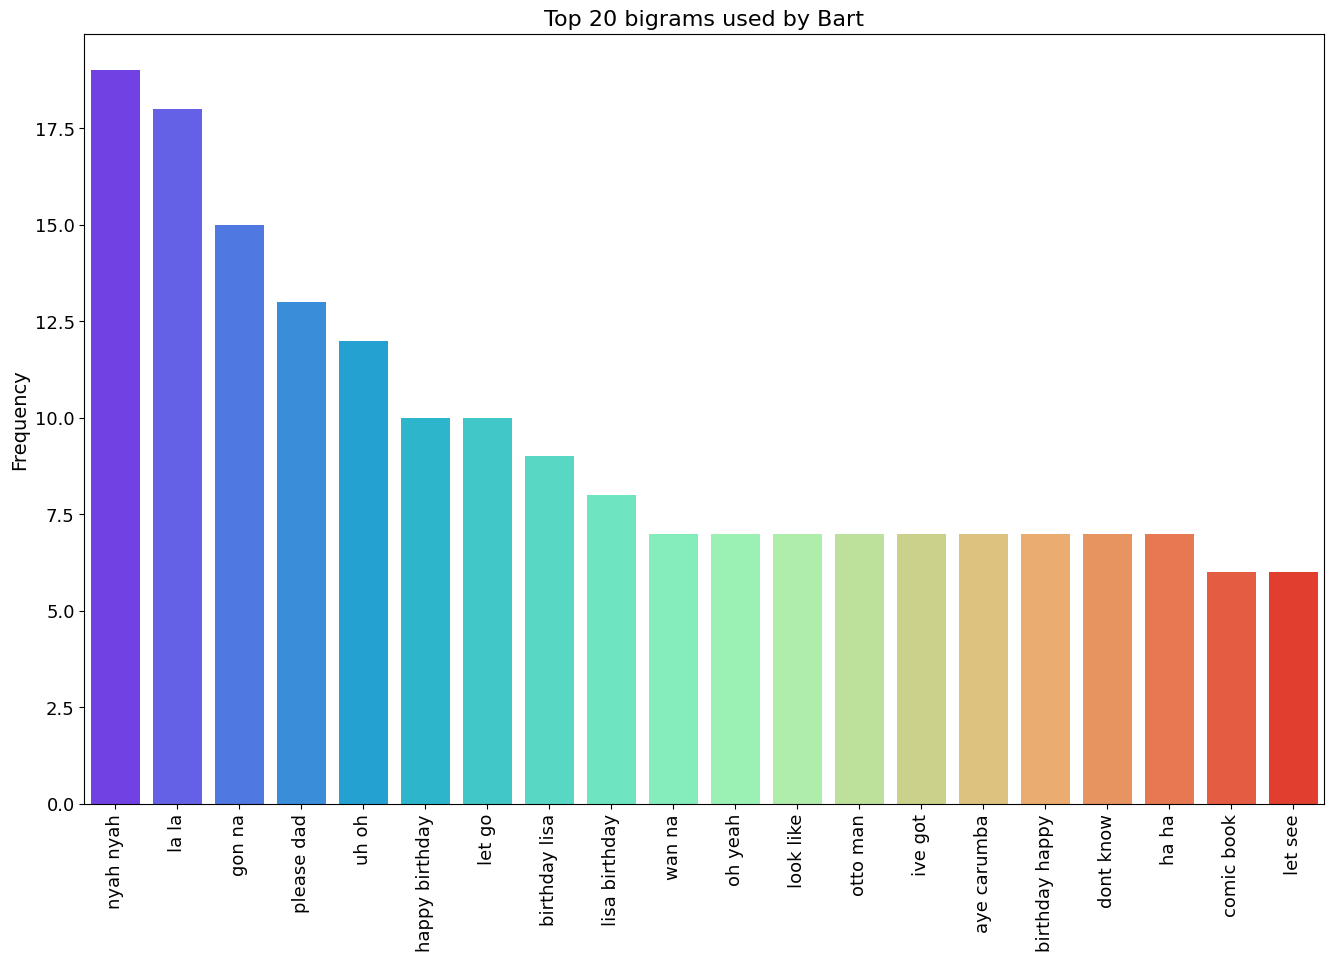

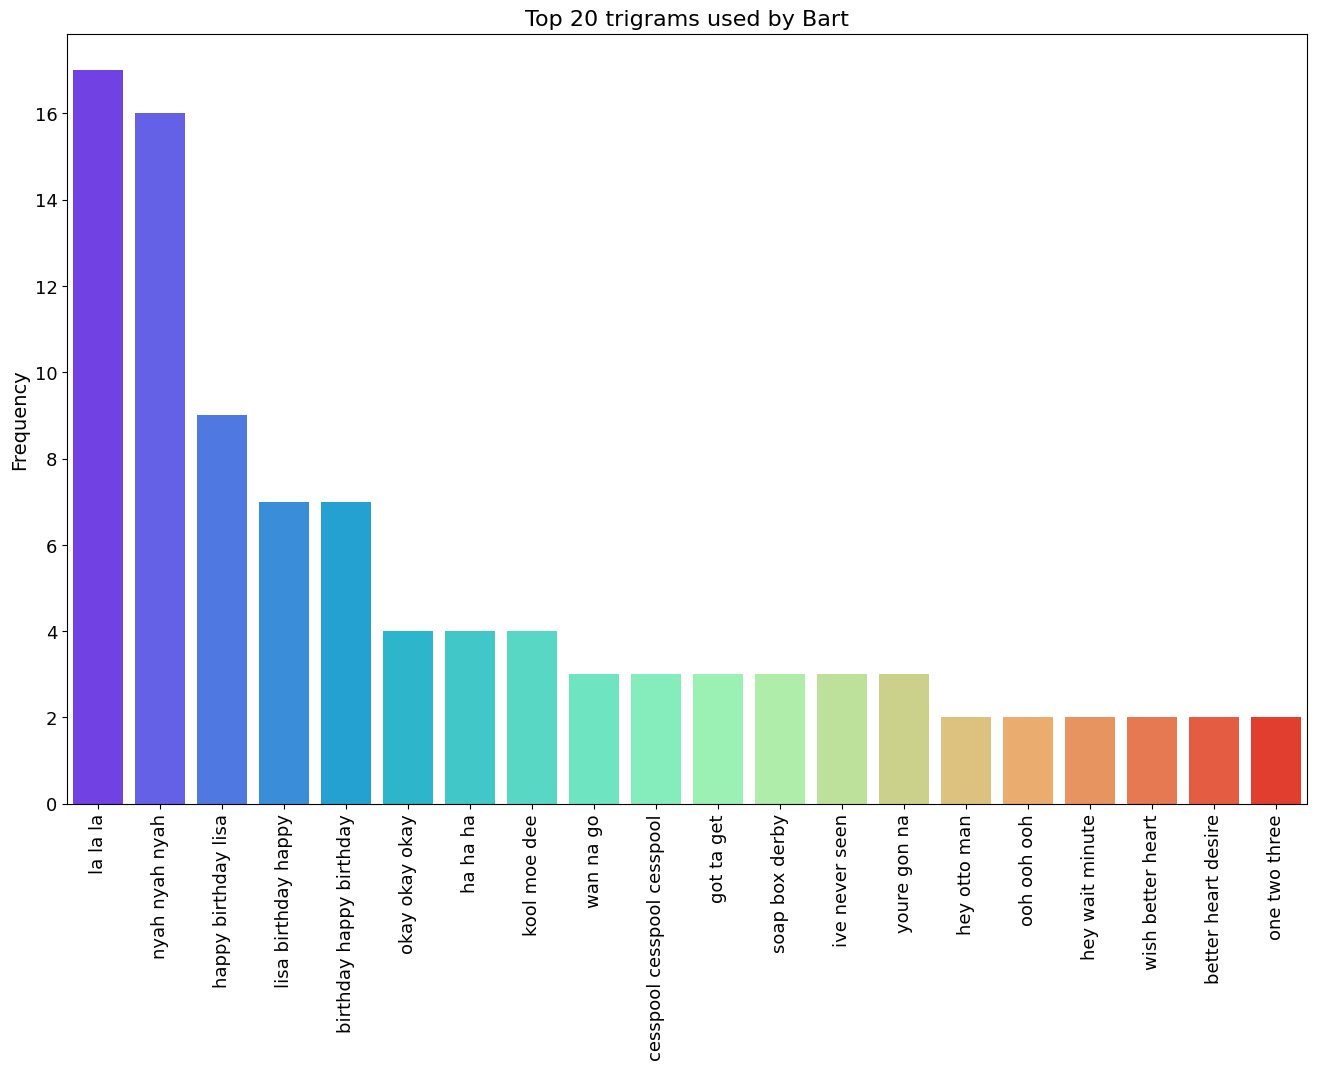

In [87]:
plot(get_top_n_bigram,bart,"Bart","bigrams",'rainbow')
plot(get_top_n_trigram,bart,"Bart","trigrams",'rainbow')

____
## LISA

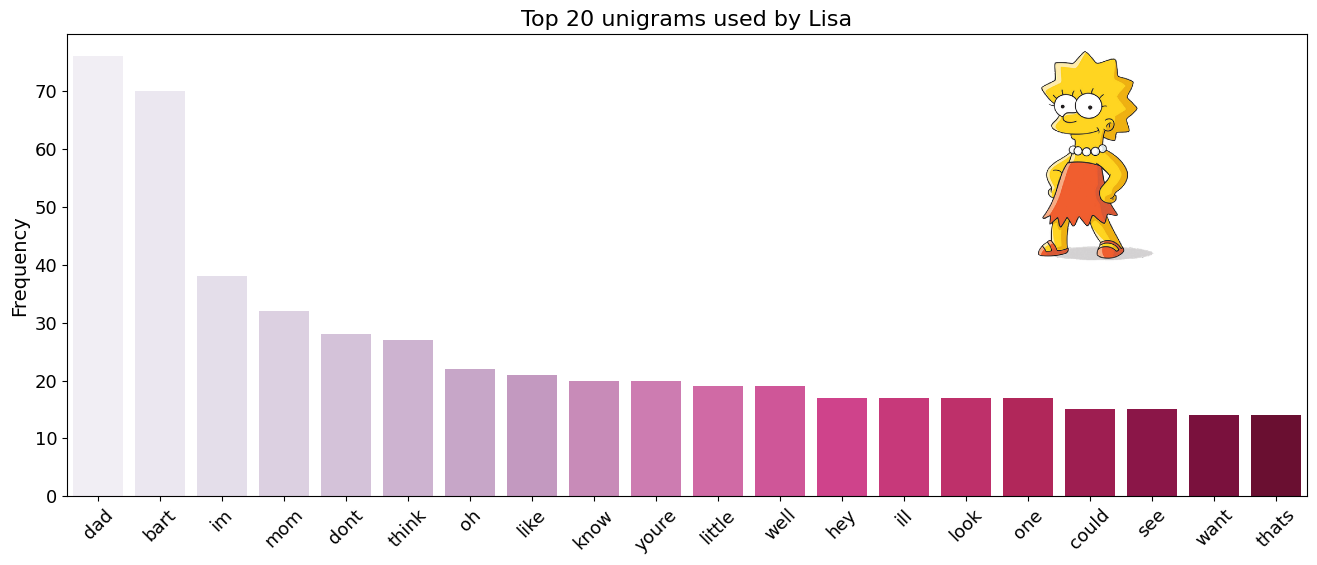

In [96]:
common_words = get_top_n_words(lisa['normalized_text_new'], 20)
common_words_df = DataFrame (common_words,columns=['word','freq'])
character_img = mpimg.imread('lisa.png')
imagebox = OffsetImage(character_img, zoom=0.4)
xy = (0.5, 0.7)
ab = AnnotationBbox(imagebox, xy,
                    xybox=(16, 58),
                    pad=0.5,frameon=False
                    )
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='word', y='freq', data=common_words_df,palette='PuRd')
ax.add_artist(ab)

plt.title("Top 20 unigrams used by Lisa", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

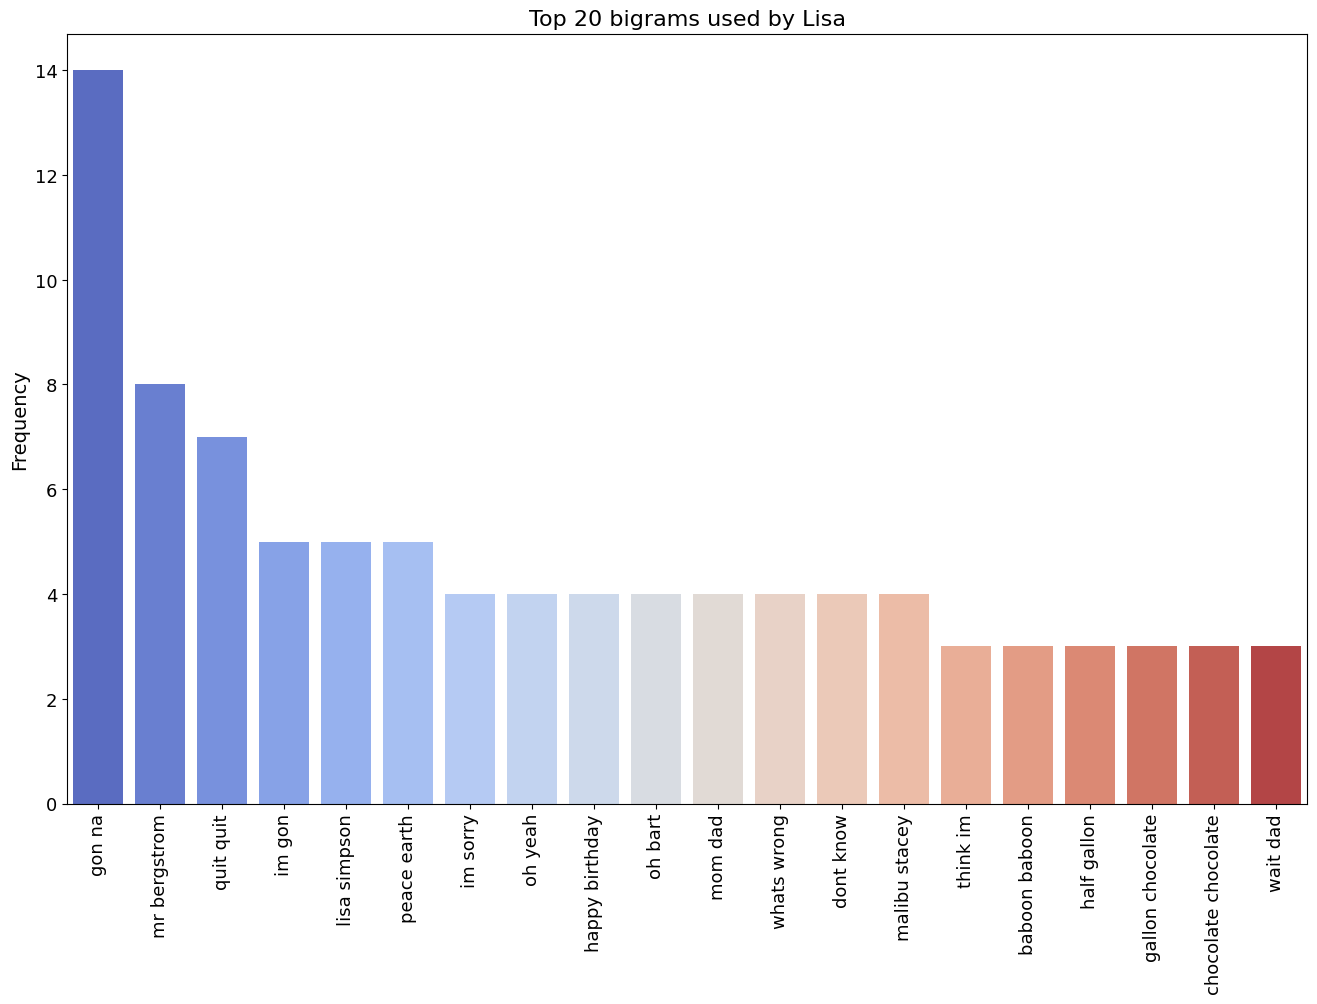

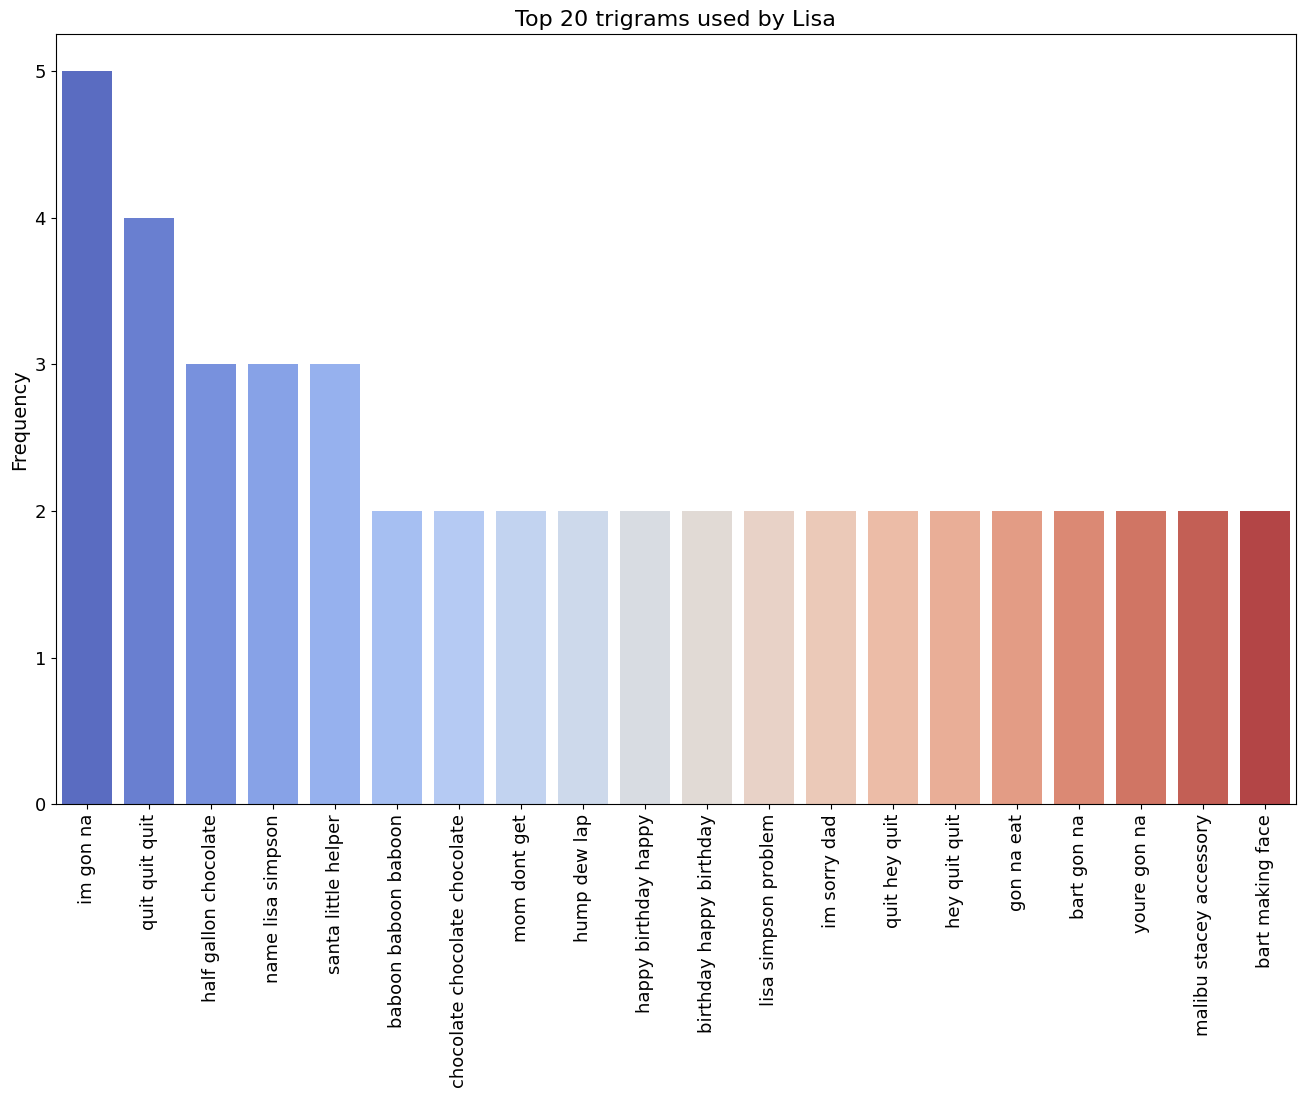

In [101]:
plot(get_top_n_bigram,lisa,"Lisa","bigrams","coolwarm")
plot(get_top_n_trigram,lisa,"Lisa","trigrams","coolwarm")

____
## Homer

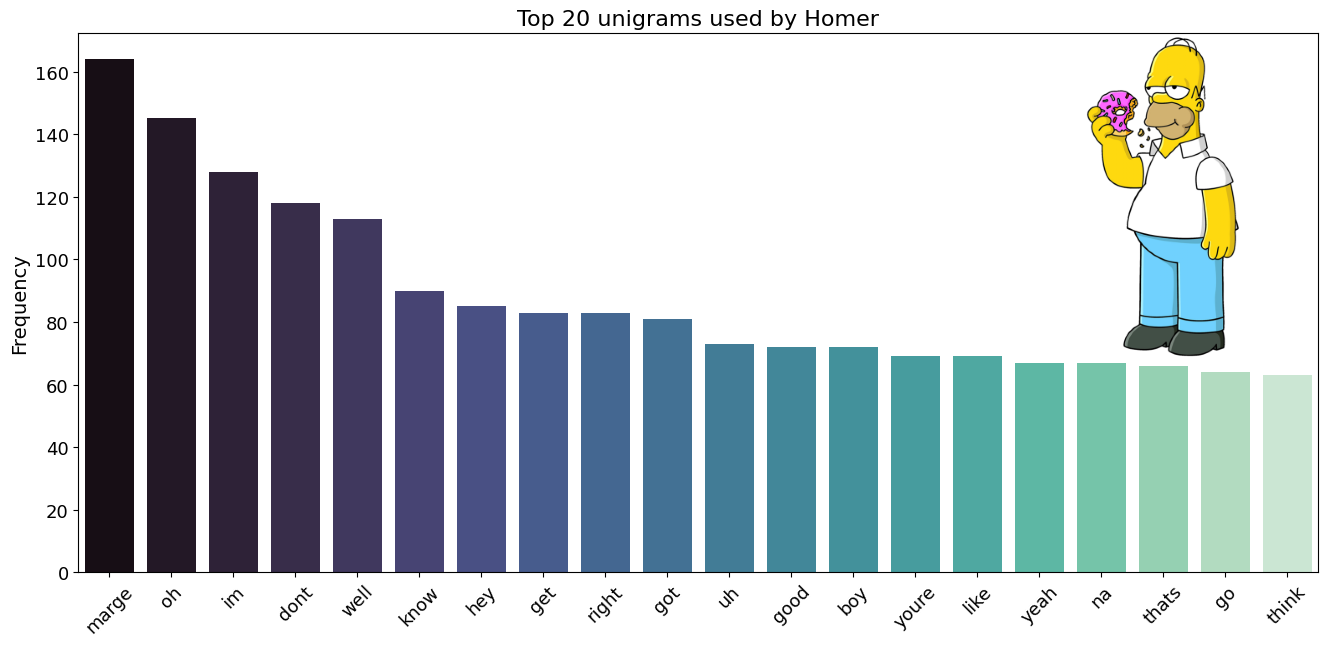

In [116]:
common_words = get_top_n_words(homer['normalized_text_new'], 20)
common_words_df = DataFrame (common_words,columns=['word','freq'])
character_img = mpimg.imread('homer.png')
imagebox = OffsetImage(character_img, zoom=0.6)
xy = (0.5, 0.7)
ab = AnnotationBbox(imagebox, xy,
                    xybox=(17, 120),
                    pad=0.5,frameon=False
                    )
plt.figure(figsize=(16, 7))
ax = sns.barplot(x='word', y='freq', data=common_words_df,palette='mako')
ax.add_artist(ab)

plt.title("Top 20 unigrams used by Homer", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

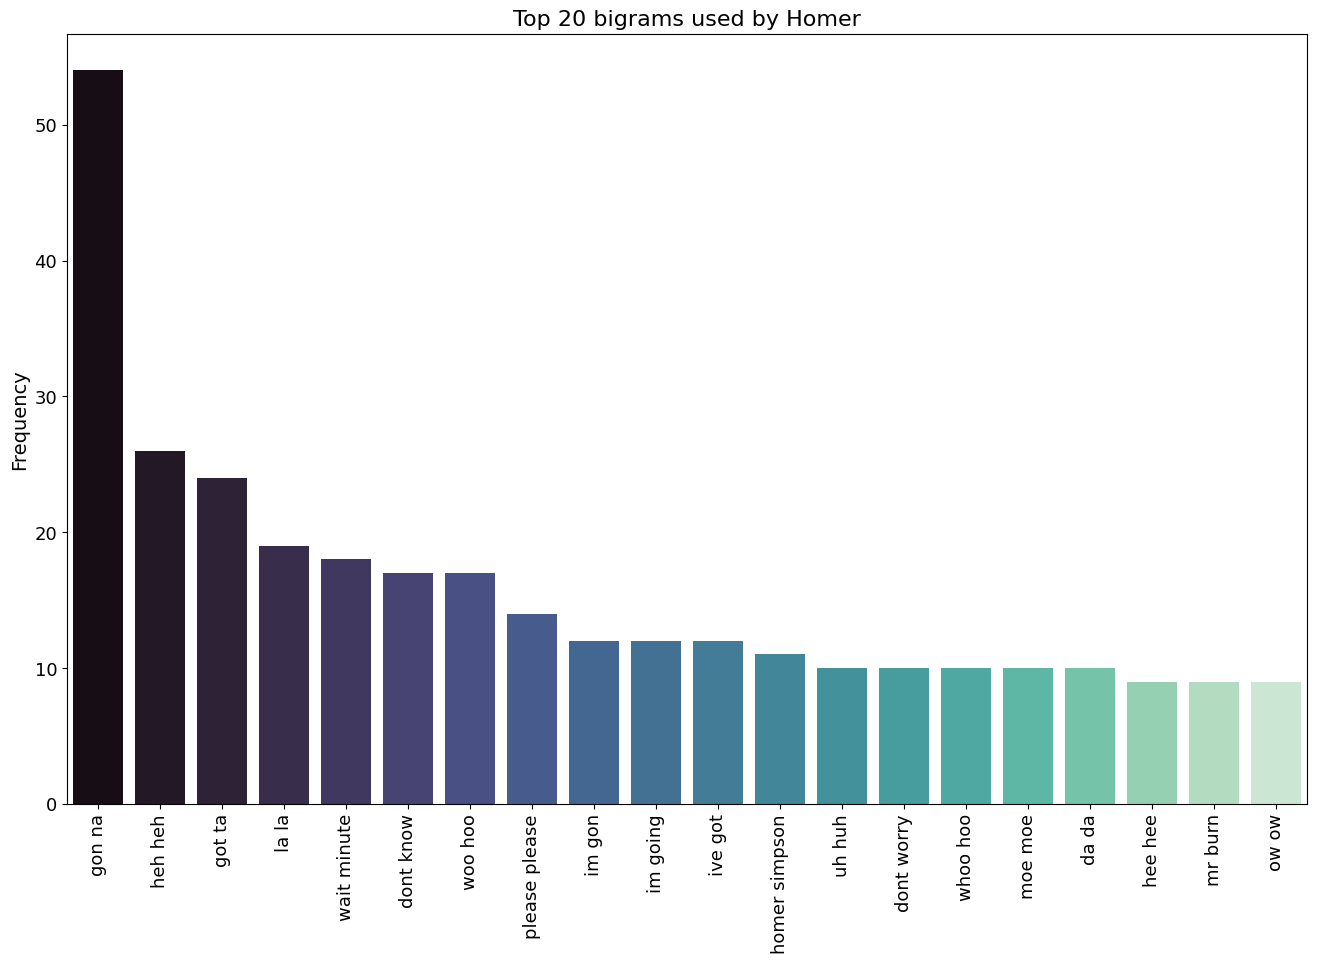

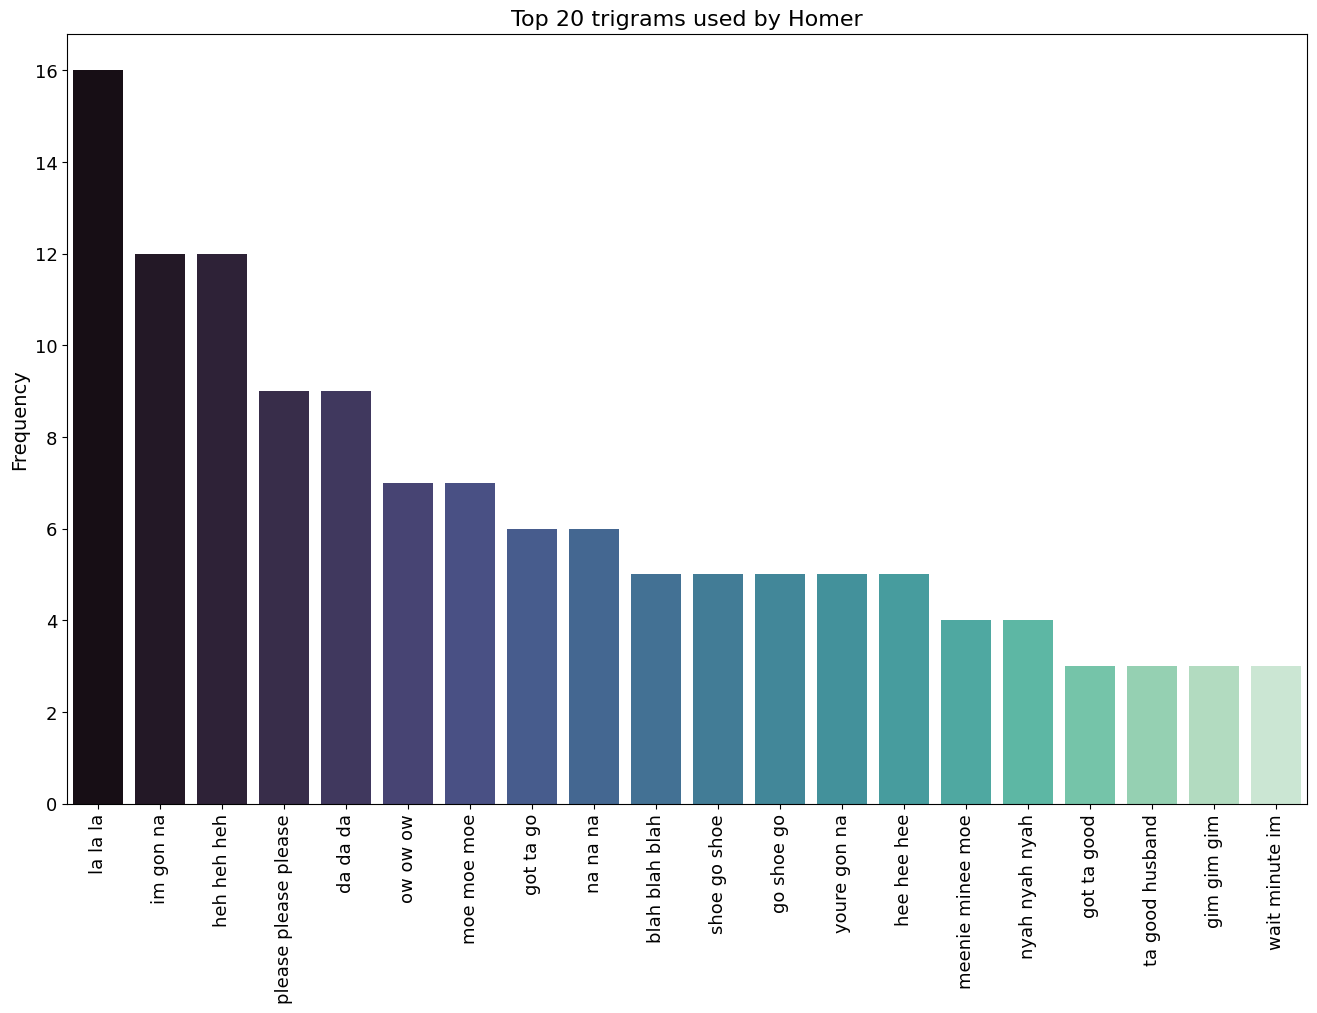

In [117]:
plot(get_top_n_bigram,homer,"Homer","bigrams",'mako')
plot(get_top_n_trigram,homer,"Homer","trigrams",'mako')

_____
## Marge

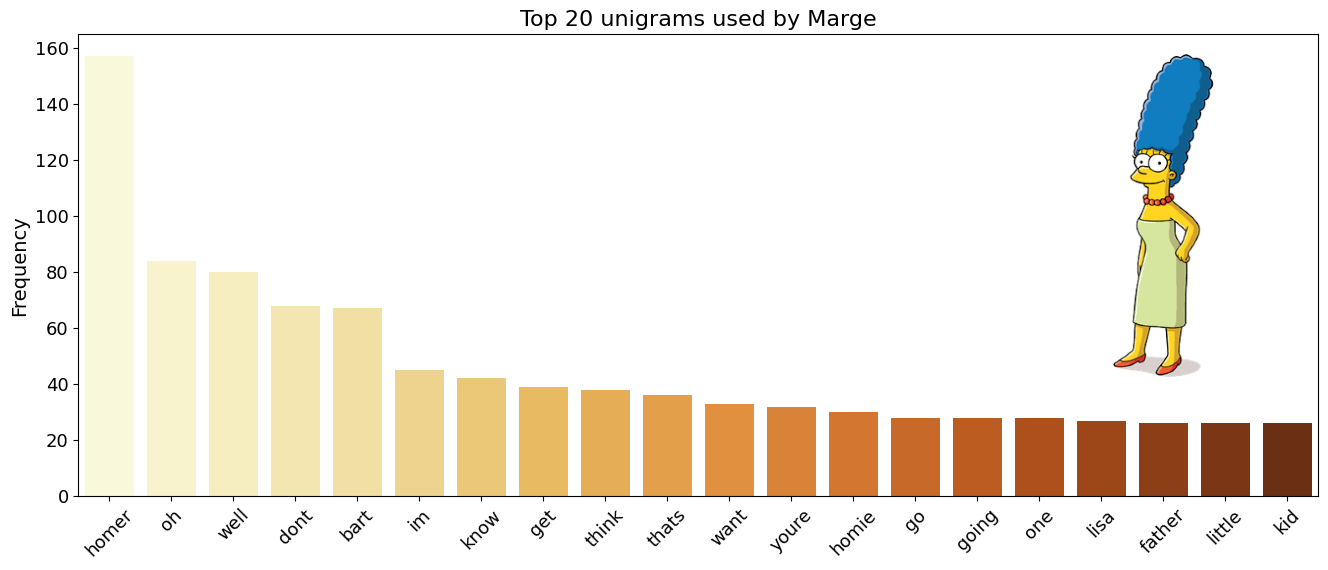

In [123]:
common_words = get_top_n_words(marge['normalized_text_new'], 20)
common_words_df = DataFrame (common_words,columns=['word','freq'])

character_img = mpimg.imread('marge.png')
imagebox = OffsetImage(character_img, zoom=0.6)
xy = (0.5, 0.7)
ab = AnnotationBbox(imagebox, xy,
                    xybox=(17, 100),
                    pad=0.5,frameon=False
                    )
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='word', y='freq', data=common_words_df,palette='YlOrBr')
ax.add_artist(ab)

plt.title("Top 20 unigrams used by Marge", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

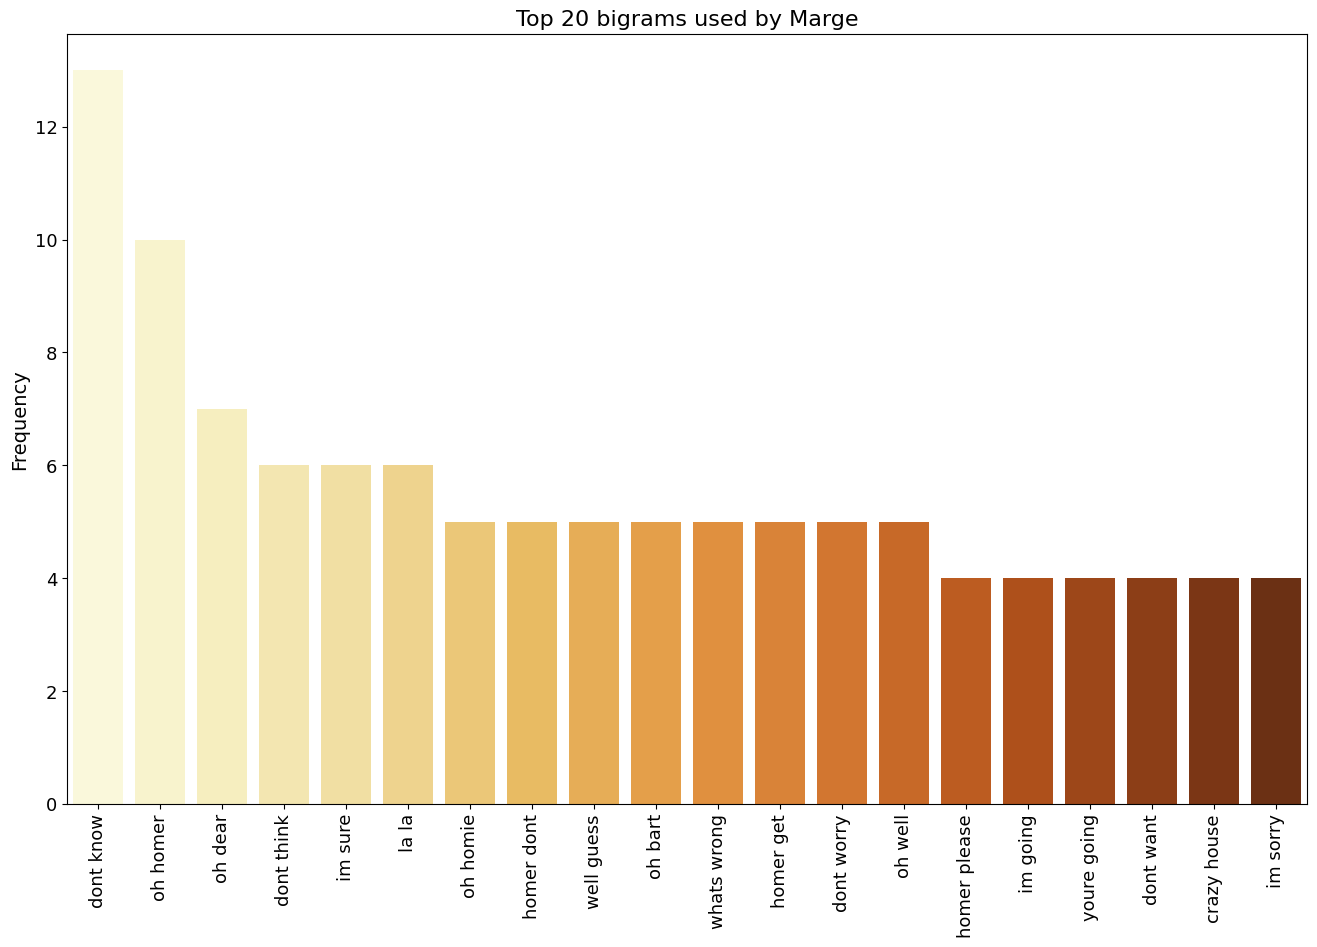

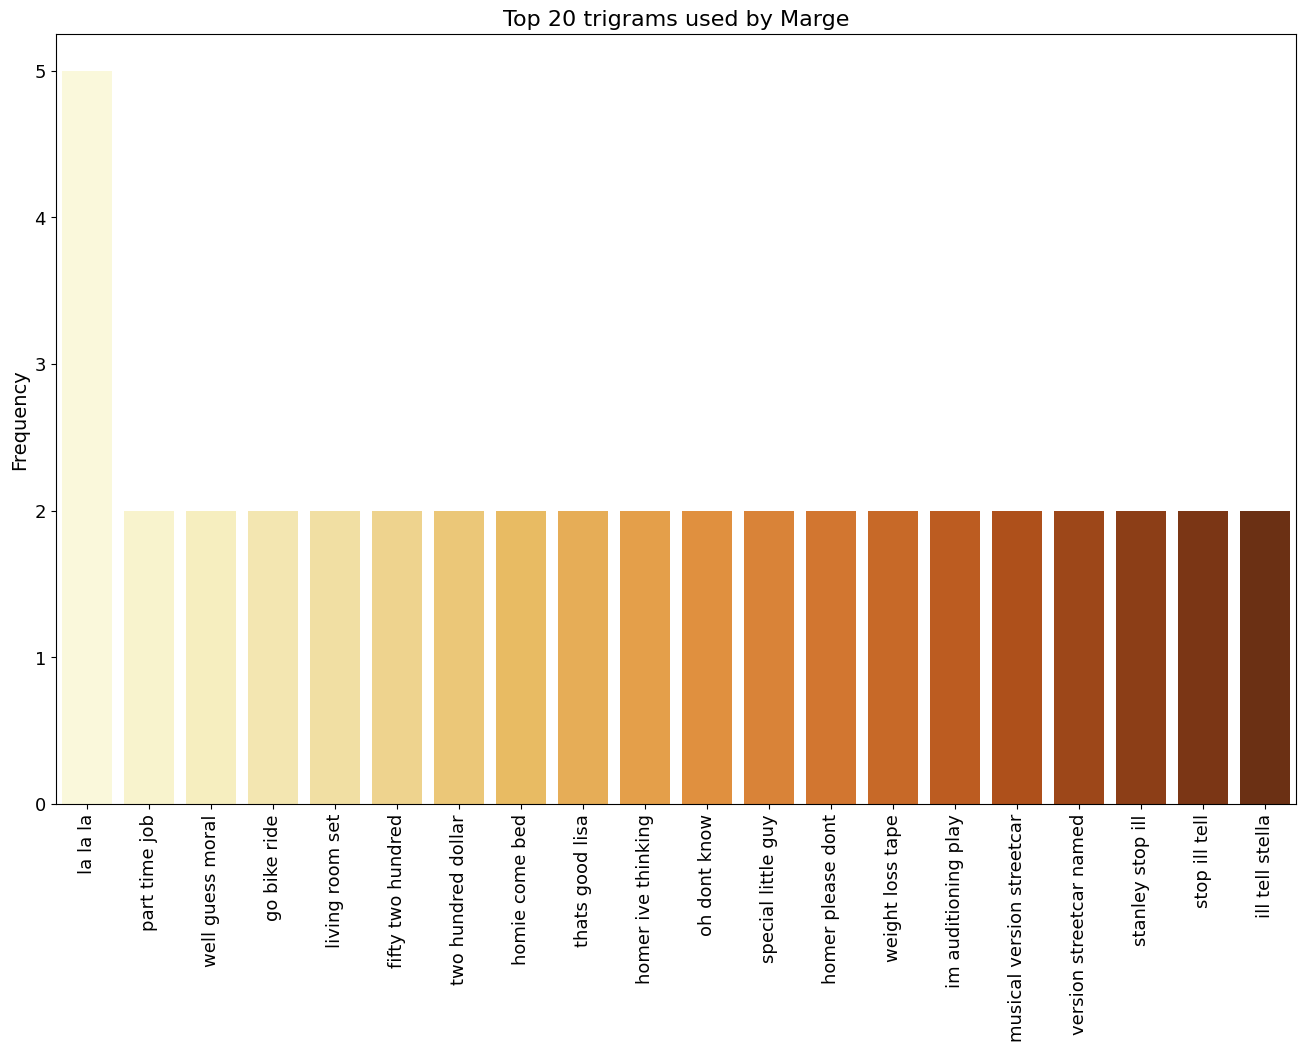

In [124]:
plot(get_top_n_bigram,marge,"Marge","bigrams",'YlOrBr')
plot(get_top_n_trigram,marge,"Marge","trigrams",'YlOrBr')

____
## Training

In [125]:
text_object = NRCLex(' '.join(df['normalized_text_new']))

In [126]:
text_object.affect_frequencies

{'fear': 0.07949285570537332,
 'anger': 0.06299054135640975,
 'anticip': 0.0,
 'trust': 0.12155363252163413,
 'surprise': 0.05747635339102435,
 'positive': 0.1876433890118736,
 'negative': 0.14670959951700543,
 'sadness': 0.0714026967196619,
 'disgust': 0.061300060374320786,
 'joy': 0.1007043670758704,
 'anticipation': 0.11072650432682632}

In [127]:
text_object.top_emotions

[('positive', 0.1876433890118736)]

In [128]:
sentiment_scores = pd.DataFrame(list(text_object.raw_emotion_scores.items()))

In [129]:
sentiment_scores = sentiment_scores.rename(columns={0: "Sentiment", 1: "Count"})
sentiment_scores

,Sentiment,Count
0,anger,1565
1,disgust,1523
2,fear,1975
3,negative,3645
4,sadness,1774
5,trust,3020
6,positive,4662
7,anticipation,2751
8,joy,2502
9,surprise,1428


In [130]:
fig = px.pie(sentiment_scores, values='Count', names='Sentiment',
             title='Sentiment Scores',
             hover_data=['Sentiment'])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [131]:
sentiment = sentiment_scores['Sentiment'].to_list()
sentiment

['anger',
 'disgust',
 'fear',
 'negative',
 'sadness',
 'trust',
 'positive',
 'anticipation',
 'joy',
 'surprise']

In [132]:
sentiment_words = pd.DataFrame(list(text_object.affect_dict.items()),columns = ['words','sentiments'])
sentiment_words

,words,sentiments
0,disease,"[anger, disgust, fear, negative, sadness]"
1,show,[trust]
2,talk,[positive]
3,lesson,"[anticipation, positive, trust]"
4,plan,[anticipation]
...,...,...
1832,vice,[negative]
1833,leaning,[trust]
1834,faithful,"[positive, trust]"
1835,departure,"[negative, sadness]"


Let's number the emotions

In [133]:
for y in sentiment:
    sentiment_words[y] = 9
sentiment_words

,words,sentiments,anger,disgust,fear,negative,sadness,trust,positive,anticipation,joy,surprise
0,disease,"[anger, disgust, fear, negative, sadness]",9,9,9,9,9,9,9,9,9,9
1,show,[trust],9,9,9,9,9,9,9,9,9,9
2,talk,[positive],9,9,9,9,9,9,9,9,9,9
3,lesson,"[anticipation, positive, trust]",9,9,9,9,9,9,9,9,9,9
4,plan,[anticipation],9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...
1832,vice,[negative],9,9,9,9,9,9,9,9,9,9
1833,leaning,[trust],9,9,9,9,9,9,9,9,9,9
1834,faithful,"[positive, trust]",9,9,9,9,9,9,9,9,9,9
1835,departure,"[negative, sadness]",9,9,9,9,9,9,9,9,9,9


In [134]:
a=0
for i in sentiment_words['sentiments']: 
    for y in sentiment:
        sentiment_words[y][a] = int(y in i)
    a=a+1

In [137]:
sentiment_words.head()

,words,sentiments,anger,disgust,fear,negative,sadness,trust,positive,anticipation,joy,surprise
0,disease,"[anger, disgust, fear, negative, sadness]",1,1,1,1,1,0,0,0,0,0
1,show,[trust],0,0,0,0,0,1,0,0,0,0
2,talk,[positive],0,0,0,0,0,0,1,0,0,0
3,lesson,"[anticipation, positive, trust]",0,0,0,0,0,1,1,1,0,0
4,plan,[anticipation],0,0,0,0,0,0,0,1,0,0


In [139]:
from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA

In [147]:
for y in sentiment:
    word_list = sentiment_words[sentiment_words[y]== 1].words.head(10)
    print(f"{y_}Sentiment: {y.upper()}")
    print(f"{g_}{word_list.values}\n")

Sentiment: ANGER
['disease' 'backbone' 'vote' 'demand' 'fraud' 'pretending' 'ill' 'lie'
 'hate' 'hurt']

Sentiment: DISGUST
['disease' 'ill' 'lie' 'hate' 'baboon' 'feeling' 'gag' 'boy' 'painful'
 'toxic']

Sentiment: FEAR
['disease' 'case' 'spike' 'sweat' 'god' 'ill' 'problem' 'abandon' 'hate'
 'hurt']

Sentiment: NEGATIVE
['disease' 'case' 'touched' 'vote' 'demand' 'leave' 'fraud' 'pretending'
 'ill' 'lie']

Sentiment: SADNESS
['disease' 'case' 'vote' 'leave' 'ill' 'lie' 'problem' 'abandon' 'cry'
 'hate']

Sentiment: TRUST
['show' 'lesson' 'teach' 'poll' 'statement' 'victory' 'backbone' 'vote'
 'president' 'teacher']

Sentiment: POSITIVE
['talk' 'lesson' 'teach' 'worth' 'statement' 'victory' 'job' 'traditional'
 'backbone' 'vote']

Sentiment: ANTICIPATION
['lesson' 'plan' 'thought' 'victory' 'vote' 'long' 'track' 'delight'
 'coming' 'tomorrow']

Sentiment: JOY
['teach' 'victory' 'vote' 'delight' 'god' 'true' 'glad' 'feeling'
 'confidence' 'happy']

Sentiment: SURPRISE
['teach' 'vote' 